**Импортируем библиотеки**

In [1]:
!pip install transformers keras_preprocessing

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import os
import numpy as np
from numpy.linalg import norm
import pickle
import matplotlib.pyplot as plt
import itertools
from scipy.stats import norm as norm_d
from scipy.stats import randint
from scipy.optimize import minimize
import copy
import math
import time
from scipy.optimize import minimize
from scipy.sparse.linalg import svds
from scipy.linalg import svdvals
import scipy
from sklearn.datasets import load_svmlight_file
import pickle
from pathlib import Path
import matplotlib.pyplot as plt
from torch.optim import Optimizer
import scipy.stats
import tqdm
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertForSequenceClassification, DistilBertTokenizer,BertTokenizer,DistilBertForSequenceClassification
import pandas as pd
import torch.nn as nn
import torch
from keras_preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef
import torchvision
import torchvision.transforms as transforms
import pandas as pd
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

In [3]:
import pathlib
if not pathlib.Path('./functions.py').is_file():
  # !wget https://raw.githubusercontent.com/alexrogozin12/opt_in_ml/master/homework_5/tests.py
  !wget https://raw.githubusercontent.com/alexrogozin12/opt_in_ml/master/homework_5/functions.py #alexrogozin12/opt_in_ml/blob/master/homework_5/functions.py
  !wget https://raw.githubusercontent.com/alexrogozin12/opt_in_ml/master/homework_5/datasets/a9a.txt
  !wget https://raw.githubusercontent.com/alexrogozin12/opt_in_ml/master/homework_5/datasets/a5a.txt
from functions import *
# from tests import *

### Решаемая задача
Для удобства продублируем здесь задачу, которую вы решали ещё в прошлом домашнем задании:

$$ F(x) = f(x) + R(x) = \frac{1}{m}\sum\limits_{i=1}^m\underbrace{\left(\log\left(1 + \exp\left(-y_i\cdot (Ax)_i\right)\right) + \frac{l_2}{2}\|x\|_2^2\right)}_{f_i(x)} + \underbrace{l_1\|x\|_1}_{R(x)} \to \min\limits_{x\in\mathbb{R}^n} $$

предобработка данных, согласно прошлому заданию

In [4]:
def prepare_data(dataset):
    filename = dataset + ".txt"

    data = load_svmlight_file(filename)
    A, y = data[0], data[1]
    m, n = A.shape
    
    if (2 in y) & (1 in y):
        y = 2 * y - 3
    if (2 in y) & (4 in y):
        y = y - 3
    assert((-1 in y) & (1 in y))
    
    sparsity_A = A.count_nonzero() / (m * n)
    return A, y, m, n, sparsity_A

def compute_L(dataset, A):
    filename = dataset+"_L.txt"
    file_path = Path(filename)
    if file_path.is_file():
        with open(filename, 'rb') as file:
            L, average_L, worst_L = pickle.load(file)
    else:
        sigmas = svds(A, return_singular_vectors=False)
        m = A.shape[0]
        L = sigmas.max()**2 / (4*m)
        
        worst_L = 0
        average_L = 0
        denseA = A.toarray()
        for i in range(m):
            L_temp = (norm(denseA[i])**2)*1.0 / 4
            average_L += L_temp / m
            if L_temp > worst_L:
                worst_L = L_temp
        with open(filename, 'wb') as file:
            pickle.dump([L, average_L, worst_L],file)
    return L, average_L, worst_L

In [5]:
dataset = "a9a"
A, y, m, n, sparsity_A = prepare_data(dataset)
print("Число функций в сумме: ", m, ", размерность задачи: ", n)
L, average_L, worst_L = compute_L(dataset, A) #L может зависеть от запуска, поэтому для каждой задачи нужно сохранить свою константу L
print("Константа гладкости всей функции: ", L)
print("Средняя константа гладкости     : ", average_L)
print("Худшая константа гладкости      : ", worst_L)
print("Доля ненулевых элементов: ", sparsity_A)

Число функций в сумме:  32561 , размерность задачи:  123
Константа гладкости всей функции:  1.5719196992226614
Средняя константа гладкости     :  3.467276803535652
Худшая константа гладкости      :  3.5
Доля ненулевых элементов:  0.11275696922074716


## Задание №1 

__*данное задание стоит 3 балла*__ 


### Пункт №1

__*данный пункт стоит 1 балл*__

Реализуйте метод оптимизации Adam для логистической регрессии

$$
\large
\begin{align}
m_t &= \beta_1 \ m_{t-1} + (1 - \beta_1)\ g  \\ 
v_t &= \beta_2 \ v_{t-1} +  (1-\beta_2)\ g_{t}^2\\
\hat{m_t} &= \frac{m_t}{1 - \beta_1^t}\\
\hat{v_t} &= \frac{v_t}{1 - \beta_2^t}\\
\theta_t &= \theta_{t-1} -  (\frac{\gamma}{\sqrt{\hat{v_t}} + \delta}\hat{m_t})\\
\end{align}
$$

https://arxiv.org/pdf/1412.6980.pdf

In [6]:
# from functions import *
def adam(filename, x_init, A, y, gamma, beta1, beta2, delta=1e-8, 
         l2=0, sparse_full=True, sparse_stoch=False, l1=0, S=50, max_t=np.inf,
         batch_size=1, indices=None, save_info_period=100, x_star=None):
    m, n = A.shape
    assert(len(x_init) == n)
    assert(len(y) == m)
    if indices is None:
        indices = randint.rvs(low=0, high=m, size=min(int(S*m*1.0/batch_size), int(100000/batch_size))*batch_size,random_state=42)
    indices_size = len(indices)
    if x_star is None:
        x_star = np.zeros(n)
    ref_point = np.array(x_star) #если знаем решение, то ref_point поможет вычислять расстояние до него
    x = np.array(x_init)
    mm = np.zeros(n)
    v = np.zeros(n)
    
    #эти массивы мы будем сохранять в файл
    its = np.array([0])
    tim = np.array([0.0])
    data_passes = np.array([0.0])
    func_val = np.array([F(x, [A, y, l2, sparse_full, l1])])
    sq_distances = np.array([norm(x - ref_point) ** 2])
    
    t_start = time.time()
    num_of_data_passes = 0.0
    
    if sparse_stoch:
        A_for_batch = A
    else:
        A_for_batch = A.toarray()
    
    indices_counter = 0
    
    #метод
    print(int(S*m/batch_size))
    for it in range(int(S*m/batch_size)):
        if indices_counter == indices_size:
            indices_counter = 0
            indices = randint.rvs(low=0, high=m, size=indices_size)
        batch_ind = indices[indices_counter:(indices_counter+batch_size)]
        indices_counter += batch_size
        #ваш код здесь
        g = logreg_grad(x, [A_for_batch[indices], y[indices], l2, sparse_stoch])
        mm = beta1 * mm + (1 - beta1) * g
        v = beta2 * v + (1 - beta2) * g ** 2
        m_hat = m / (1-beta1**(it+1))
        v_hat = v / (1-beta2**(it+1))
        x = x - gamma*m_hat/(v_hat + delta)

        num_of_data_passes += batch_size/m
        if ((it + 1) % save_info_period == 0):
            its = np.append(its, it + 1)
            tim = np.append(tim, time.time() - t_start)
            data_passes = np.append(data_passes, num_of_data_passes)
            func_val = np.append(func_val, F(x, [A, y, l2, sparse_full, l1]))
            sq_distances = np.append(sq_distances, norm(x - ref_point) ** 2)
        if tim[-1] > max_t:
            break
    
    if ((it + 1) % save_info_period != 0):
        its = np.append(its, it + 1)
        tim = np.append(tim, time.time() - t_start)
        data_passes = np.append(data_passes, num_of_data_passes)
        func_val = np.append(func_val, F(x, [A, y, l2, sparse_full, l1]))
        sq_distances = np.append(sq_distances, norm(x - ref_point) ** 2)
    
    #сохранение результатов в файл
    res = {'last_iter':x, 'func_vals':func_val, 'iters':its, 'time':tim, 'data_passes':data_passes,
           'squared_distances':sq_distances}
    if not os.path.isdir('./dump'):
      os.mkdir('./dump')
    with open("dump/"+filename+"_Adam_gamma_"+str(gamma)+"_beta1_"+str(beta1)+"_beta2_"+str(beta2)
              +"_l2_"+str(l2)+"_l1_"+str(l1)+"_num_of_epochs_"+str(S)
              +"_batch_size_"+str(batch_size)+".txt", 'wb') as file:
        pickle.dump(res, file)

    return res


In [ ]:
%%time
np.random.seed(10)
x_init = np.ones(n)
dataset = "a9a"
filename=dataset+"_x_init_all_ones"
l2 = L / 10000
l1 = L / 1000
batch_size = 10
gamma_gd = 1.0/((L+l2))
gamma = 1.0/(6*(L+l2))
gamma_schedule = [gamma, 10, 0.5]
S = 10000
beta1 = 0.9
gamma_adam = 0.001
gamma_adagrad = 1.0
beta2 = 0.99
indices = None

res = adam(filename=filename, x_init=x_init, A=A, y=y, gamma=gamma_adam,
           beta1=beta1, beta2=beta2, l2=l2, 
           sparse_full=False, sparse_stoch=False, l1=l1, S=S, batch_size=batch_size)


CPU times: user 97 µs, sys: 15 µs, total: 112 µs
Wall time: 116 µs


Тестируем

In [ ]:
if not pathlib.Path('./Adam_test.txt').is_file():
  !wget https://raw.githubusercontent.com/pcgames/datasets/master/tests/Adam_test.txt
with open('./Adam_test.txt','rb') as f:
  test_res=pickle.load(f)
assert (abs(test_res['last_iter']-res['last_iter'])<1e-6).all(),'что-то не так...'

--2023-05-31 08:42:44--  https://raw.githubusercontent.com/pcgames/datasets/master/tests/Adam_test.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13025933 (12M) [application/octet-stream]
Saving to: ‘Adam_test.txt’

Adam_test.txt       100%[===================>]  12.42M  --.-KB/s    in 0.1s    

2023-05-31 08:42:45 (118 MB/s) - ‘Adam_test.txt’ saved [13025933/13025933]



NameError: ignored

### Пункт №2

__*данный пункт стоит 1 балл*__

Сравните результаты данного экспермента с результатами, полученными в прошлом домашнем задании для методов  __SGD__, __SVRG__ и ускоренным методом Нестерова (метод __FISTA__ без prox_r):
- Нарисуйте графики сходимости
- Исходя из теории, полученной на лекции, обоснуйте результаты, полученные в эксперименте, а так же сделайте выводы о работе данных методов на поставленной задаче.

In [ ]:
from algorithms import *


res_sgd = sgd_const_stepsize(filename=filename, x_init=x_init, A=A, y=y, gamma=gamma, l2=l2, 
     sparse_full=False, sparse_stoch=False, 
     l1=l1, S=S, max_t=np.inf, batch_size=batch_size)

res_svrg = svrg(filename=filename, x_init=x_init, A=A, y=y, gamma=gamma, l2=l2, 
     sparse_full=False, sparse_stoch=False, 
     l1=l1, S=S, max_t=np.inf,
     batch_size=batch_size, indices=None)

res_fista = FISTA(filename=filename, x_init=x_init, A=A, y=y, L=L+l2, mu=l2, 
     sparse=False, l1=l1, S=S, max_t=np.inf)

KeyboardInterrupt: ignored

In [ ]:
plt.plot(res['func_vals'], label='Adam')
plt.plot(res_sgd['func_vals'], label='SGD')
plt.plot(res_svrg['func_vals'], label='SVRG')

plt.plot(res_fista['func_vals'], label='FISTA')
plt.legend()

# dataset = "a9a"
# filename=dataset+"_x_init_all_ones"

# methods = [
#          ['Adam', [l2, l1, S], f', S ={S}, ', None]
#          ['SGD', [l2, l1, S], f', S ={S}, ', None]
#          ['SVRG', [l2, l1, S], f', S ={S}, ', None]
#          ['FISTA', [l2, l1, S], f', S ={S}, ', None]
# ]

# mode_y = 'squared_distances'
# mode_x = 'time'
# figsize = (12, 8)
# fontsize = 20
# title = dataset+", (m,n) = ("+str(m)+","+str(n)+"), l2 = L/"+str(int(L/l2))+", l1 = L/"+str(int(L/l1))

# args_for_plots = [dataset, filename, mode_y, mode_x, figsize, fontsize, title, methods]
# make_plots(args=args_for_plots)
# plt.show()

*Описать результат*

### Пункт №3 

__*данный пункт стоит 1 балл*__

Проведите аналогичный эксперимент на другом датасете, сохраните результат и отправьте его вместе с домашним заданием

In [ ]:
dataset = "a5a"
A, y, m, n, sparsity_A = prepare_data(dataset)
print("Число функций в сумме: ", m, ", размерность задачи: ", n)
L, average_L, worst_L = compute_L(dataset, A) #L может зависеть от запуска, поэтому для каждой задачи нужно сохранить свою константу L
print("Константа гладкости всей функции: ", L)
print("Средняя константа гладкости     : ", average_L)
print("Худшая константа гладкости      : ", worst_L)
print("Доля ненулевых элементов: ", sparsity_A)
%%time
np.random.seed(10)
x_init = np.ones(n)
dataset = "a5a"
filename=dataset+"_x_init_all_ones"
l2 = L / 10000
l1 = L / 1000
batch_size = 10
gamma_gd = 1.0/((L+l2))
gamma = 1.0/(6*(L+l2))
gamma_schedule = [gamma, 10, 0.5]
S = 10000
beta1 = 0.9
gamma_adam = 0.001
gamma_adagrad = 1.0
beta2 = 0.99
indices = None

res = adam(filename=filename, x_init=x_init, A=A, y=y, gamma=gamma_adam,
           beta1=beta1, beta2=beta2, l2=l2, 
           sparse_full=False, sparse_stoch=False, l1=l1, S=S, batch_size=batch_size)


## Задание №2

__*данное задание стоит 4 балла*__

### Пункт №1
__*данный пункт стоит 2 балла*__

реализовать метод оптимизации ACClip, о котором рассказывалось на лекции  
$$
\large
\begin{align}
for \, k=&1\cdots N- количество \, эпох\, прохода\, по\, данным\\
&for \, t=1\cdots T- количество \, частей\, , на \, которое \,разделен \, весь \, датасет\,рандомным\,образом\\
&\,\,\,\,\,\,\,\,m_t = \beta_1 \ m_{t-1} + (1 - \beta_1)\ g_t \\ 
&\,\,\,\,\,\,\,\, \tau^\alpha_t = \beta_2 \tau_{t-1}^\alpha +  (1-\beta_2)\ g_{t}^\alpha  \\
&\,\,\,\,\,\,\,\,\hat{g_t} = \min\{\frac{\tau_t}{|m_t|+\epsilon},1\}m_t \\
%\hat{v_t} = \frac{v_t}{1 - \beta^t}\\
&\,\,\,\,\,\,\,\,\theta_t = \theta_{t-1} -  \eta \hat{g_t}\\
& endfor\\
endfor
\end{align}
$$

https://arxiv.org/pdf/1912.03194.pdf


In [7]:
class ACC(Optimizer):
    def __init__(self, 
                 params, 
                 lr=1e-4, 
                 betas=(0.9, 0.99), 
                 eps=1e-5,
                 w=1e-5,
                 alpha=2):

        defaults = dict(lr=lr, betas=betas, eps=eps,weight_decay=w,alpha=2)
        # тут вызываем конструктор базового класса и сохраняем параметры обучения
        # их можно достать через self.param_groups
        super(ACC, self).__init__(params, defaults)

    def step(self,closure=None):

        loss = None

        for group in self.param_groups:
            # итерируемся по всем группам параметров нашей сети
            # тут можно вытащить сохраненные параметры в группе
            beta1, beta2 = group['betas'] 
            eps = group['eps']
            w = group['weight_decay']
            lr = group['lr']
            alpha=group['alpha']

            for p in group['params']:
                # итерируемся по всем парамерам в данно группе
                # если нет градиента по параметрам скипаем его
                if p.grad is None:
                    continue
                # забираем тензор градиента    
                grad = p.grad.data
                
                # тут храняться значения, которые мы расчитываем в процессе 
                # по каждому параметру в группе нужно расчитывать свои значения
                state = self.state[p]

                # если параметры мы еще не записали инициализируем их значения
                if len(state) == 0:
                    state['step'] = 0
                    #начальное значение m
                    state['momentum'] = torch.zeros_like(p.data)

                    # начальное значение \tau^{\alpha}
                    state['t'] = torch.zeros_like(p.data)


                t, m = state['t'], state['momentum']
                        
                # запоминаем шаг
                state['step'] += 1
                # Считаем параметры.
                m = beta1 * m + (1 - beta1) * grad
                t = torch.pow(beta2*torch.pow(t, alpha)+(1-beta2)*(grad.abs()**alpha), 1./alpha)
                g_hat = (t/(m.abs()+eps)).clamp(min=0.0, max=1.0) * m
                # обновляем веса в p.data, 
                p.data = p.data - lr * g_hat
        return loss

Протестируем реализованный метод

In [ ]:
if not pathlib.Path('./apples_pears.csv').is_file():
  !wget https://raw.githubusercontent.com/pcgames/datasets/master/apples_pears.csv
  !wget https://raw.githubusercontent.com/pcgames/datasets/master/tests/ACC_test.pt


data=pd.read_csv('./apples_pears.csv')
X = torch.FloatTensor(data.iloc[:,:2].values) # матрица объекты-признаки
y = torch.LongTensor(data['target'].values.reshape((-1, 1))).view(-1)  # классы (столбец из нулей и единиц)

torch.manual_seed(10)
np.random.seed(10)
NN=nn.Sequential(nn.Linear(X.shape[1],
                                torch.unique(y).shape.numel()
                                ),
                       )
loss_fn=torch.nn.CrossEntropyLoss(size_average=False)

learning_rate = 0.01  
optimizer = ACC(NN.parameters(), lr=learning_rate)
for t in range(500):
    y_pred=NN.forward(X)
    loss = loss_fn(y_pred,y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
testing_NN=nn.Sequential(nn.Linear(X.shape[1],
                                torch.unique(y).shape.numel()
                                ),
                       )
testing_NN.load_state_dict(torch.load('./ACC_test.pt'))
a=testing_NN.parameters()

for b in NN.parameters():
  c=next(a).data.clone()
  d=b.data.clone()
  assert ((c-d).abs()<1e-6).values, 'что-то не так!'


--2023-06-02 06:05:48--  https://raw.githubusercontent.com/pcgames/datasets/master/apples_pears.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 42590 (42K) [text/plain]
Saving to: ‘apples_pears.csv’

apples_pears.csv    100%[===================>]  41.59K  --.-KB/s    in 0.003s  

2023-06-02 06:05:48 (12.4 MB/s) - ‘apples_pears.csv’ saved [42590/42590]

--2023-06-02 06:05:49--  https://raw.githubusercontent.com/pcgames/datasets/master/tests/ACC_test.pt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1153 (1.1K) [application/oct

/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


### Пункт №2
__*в данном пункте описание каждого эксперимента стоит 1 балл*__

Проведите эксперименты ,аналогичные проведенным на семинаре, с использованием алгоритма ACClip:
- Получите распределение норм разностей стох. и полного градиентов для языковой модели bert на датасете CoLA

- Получите распредиление норм разностей стох. и полного градиентов на модели VGG16 для датасета CIFAR10

Сравните результаты, с результатами полученными для алгоритмов Adam SGD+momentum и обоснуйте результаты исходя из материалов, полученных на лекции №8.

#### Предобработка данных

Загрузим датасет из семинара и проведем его предобработку 

In [ ]:
# Unzip the dataset (if we haven't already)
!pip install wget
import wget
import os
print('Downloading dataset')
# The URL for the dataset zip file.
url = 'https://nyu-mll.github.io/CoLA/cola_public_1.1.zip'
# Download the file (if we haven't already)
if not os.path.exists('./cola_public_1.1.zip'):
  wget.download(url, './cola_public_1.1.zip')
  if not os.path.exists('./cola_public/'):
    !unzip cola_public_1.1.zip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
df = pd.read_csv("./cola_public/raw/in_domain_train.tsv", delimiter='\t',
                 header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])
df

,sentence_source,label,label_notes,sentence
0,gj04,1,NaN,"Our friends won't buy this analysis, let alone..."
1,gj04,1,NaN,One more pseudo generalization and I'm giving up.
2,gj04,1,NaN,One more pseudo generalization or I'm giving up.
3,gj04,1,NaN,"The more we study verbs, the crazier they get."
4,gj04,1,NaN,Day by day the facts are getting murkier.
...,...,...,...,...
8546,ad03,0,*,Poseidon appears to own a dragon
8547,ad03,0,*,Digitize is my happiest memory
8548,ad03,1,NaN,It is easy to slay the Gorgon.
8549,ad03,1,NaN,I had the strangest feeling that I knew you.


Поскольку в данной части задания мы будем использовать тот же самый [CoLA Dataset](https://nyu-mll.github.io/CoLA/#) и ту же самую [модель](https://huggingface.co/transformers/model_doc/bert.html#bertforsequenceclassification), проведем аналогичную предобработку

In [ ]:
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
# токенизируем предложения исходного датасета
input_ids = []
# For every sentence...
for sent in df.sentence.values:
    #   (1) токинизируем предложение.
    #   (2) добавляем символ `[CLS]`в начало предложения.
    #   (3) и символ `[SEP]`в конец.
    #   (4) маркеруем все токены в их id
    encoded_sent = tokenizer.encode(
                        sent,                      
                        add_special_tokens = True, # добавляем '[CLS]' и '[SEP]'
                   )
    
    input_ids.append(encoded_sent)
print('Original: ', df.sentence.values[0])
print('Token IDs:', input_ids[0])

MAX_LEN =  max([len(sen) for sen in input_ids])+1
print('\nPadding/truncating all sentences to %d values...' % MAX_LEN)
print('\nPadding token: "{:}", ID: {:}'.format(tokenizer.pad_token, tokenizer.pad_token_id))

input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", 
                          value=0, truncating="post", padding="post")
print('\Done.')
# создадим attantion маску для кажого предложения
attention_masks = []
for sent in input_ids:
    
    # Create the attention mask.
    #   - если  ID =0 тогда не стоит обрабатывать данный токен в процессе обучения, поскольку это паддинг
    #   -  если  ID >0 тогда стоит использовать данный токен, поскольку он является частью предложения
    att_mask = [int(token_id > 0) for token_id in sent]
    
    attention_masks.append(att_mask)



train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids,df.label.values, 
                                                            random_state=2018, test_size=0.1)

train_masks, validation_masks, _, _ = train_test_split(attention_masks, df.label.values,
                                             random_state=2018, test_size=0.1)


if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

### даталоадер для вычисления полного градиента
batch_size = 250#train_inputs.shape[0]
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader_for_full_grad = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)


### для обучения
batch_size = 16#train_inputs.shape[0]
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)



Loading BERT tokenizer...
Original:  Our friends won't buy this analysis, let alone the next one we propose.
Token IDs: [101, 2256, 2814, 2180, 1005, 1056, 4965, 2023, 4106, 1010, 2292, 2894, 1996, 2279, 2028, 2057, 16599, 1012, 102]

Padding/truncating all sentences to 48 values...

Padding token: "[PAD]", ID: 0
\Done.
There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [ ]:
torch.manual_seed(15)
model = BertForSequenceClassification.from_pretrained(
  "bert-base-uncased", # 12-ти слойная модель BERT с предобученными весами
  num_labels = 2, # количество выходных хначений для бинарной классификации  
  output_attentions = False, # true, если необходимо брать attention веса модели.
  output_hidden_states = False, #true, если необходимо брать значения со скрытых слоёв.
)
# Tell pytorch to run this model on the GPU.
model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
optimizer = ACC(model.parameters(),
                 lr=1e-3, 
                 betas=(0.9, 0.99), 
                 eps=1e-5,
                 w=1e-5,
                 alpha=2)#воспользуйтесь Вашим оптимизатором

epochs = 4
total_steps = len(train_dataloader) * epochs

#### Эксперимент №1

**Функции**

воспользуемся функциями из семинарского ноутбука

In [ ]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)
    
import time
import datetime
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))
def get_batch_grad(model):
  gr=[]
  for i in model.parameters():
    if i.requires_grad:
      gr.append(i.grad.view(-1))
  return torch.cat(gr)
def get_loss(batch,model):
  b_input_ids = batch[0].to(device)
  b_input_mask = batch[1].to(device)
  b_labels = batch[2].to(device)
  outputs = model(b_input_ids, 
                      token_type_ids=None, 
                      attention_mask=b_input_mask, 
                      labels=b_labels)

  loss=outputs[0]
  return loss
def compute_full_grad(model):
  fully_grad=[]
  for step, batch in enumerate(train_dataloader_for_full_grad):
    optimizer.zero_grad()

    loss=get_loss(batch,model)
    loss.backward()

    fully_grad = fully_grad + get_batch_grad(model) * \
        train_dataloader_for_full_grad.batch_size if fully_grad!=[] \
            else get_batch_grad(model) * train_dataloader_for_full_grad.batch_size

  print("full grad computed")
  return fully_grad / (step * train_dataloader_for_full_grad.batch_size)
def draw_norm_hist(norm_diffs):
  bins_n=500
  counts, bins=np.histogram(norm_diffs,bins_n)
  mu = np.mean(norm_diffs)
  sigma = np.sqrt(np.mean((norm_diffs - mu)**2))
  temp2 = np.linspace(0, bins[-1], bins_n)
  plt.semilogy(temp2, scipy.stats.norm.pdf(temp2, mu, sigma), linewidth=2, color='red', marker='d',
            markersize = 15, 
            markevery=range(0, bins_n, 100))
  plt.hist(bins[:-1], bins, weights=counts)
  plt.yscale('log')
  plt.show()

def compute_norm_diffs(model):
  full_grad=compute_full_grad(model)
  mini_norms=[]
  for step, batch in enumerate(train_dataloader):
    optimizer.zero_grad()
    loss=get_loss(batch,model)
    loss.backward()
    mini_norms.append((get_batch_grad(model)-full_grad).norm().item())
  print("norm diffs computed")

  return np.array(mini_norms)

def training_and_drawing(model,n_epochs,optimizer):
  norm_diffs_every_epoch=[]
  for i in tqdm.tqdm(range(n_epochs)):
    model.eval()
    norm_diffs_every_epoch.append(compute_norm_diffs(model))
    if i:
      draw_norm_hist(norm_diffs_every_epoch[-1])
    else:
      draw_norm_hist(norm_diffs_every_epoch)
    print("start_training")
    model.train()
    for step, batch in enumerate(train_dataloader):
      optimizer.zero_grad()
      loss=get_loss(batch,model)
      loss.backward()
      optimizer.step()
  validation(model)
  return norm_diffs_every_epoch

def get_accuracy(model,batch):
  b_input_ids = batch[0].to(device)
  b_input_mask = batch[1].to(device)
  b_labels = batch[2].to(device)
  with torch.no_grad():
    outputs = model(b_input_ids, 
                      token_type_ids=None, 
                      attention_mask=b_input_mask, 
                      labels=b_labels)
  # print(outputs.logits)
  logits = outputs.logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
        
        # Calculate the accuracy for this batch of test sentences.


  return flat_accuracy(logits, label_ids)
def flat_accuracy(preds, labels):
  # print(preds.shape())
  pred_flat = np.argmax(preds, axis=1).flatten()
  labels_flat = labels.flatten()
  return np.sum(pred_flat == labels_flat) / len(labels_flat), matthews_corrcoef(labels_flat, pred_flat)                
def validation(model):
  print("Running Validation...")
  matthews_set=[]
  model.eval()
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0
    # Evaluate data for one epoch
  for batch in validation_dataloader:
    tmp_eval_accuracy,matthew = get_accuracy(model,batch)
    matthews_set.append(matthew)
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1
    # Report the final accuracy for this validation run.

  print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps) )
  print(" matthews_corrcoef_metric: {0:.2f}".format(np.mean(matthews_set)))

  0%|          | 0/4 [00:00<?, ?it/s]

full grad computed
norm diffs computed


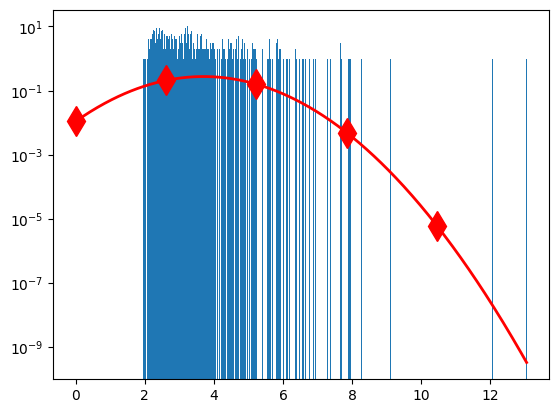

start_training


 25%|██▌       | 1/4 [03:14<09:43, 194.34s/it]

full grad computed
norm diffs computed


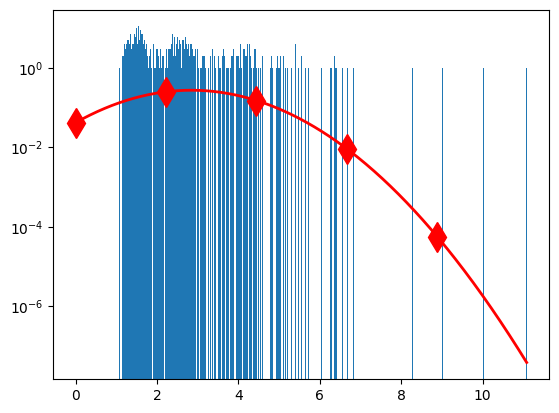

start_training


 50%|█████     | 2/4 [06:28<06:28, 194.48s/it]

full grad computed
norm diffs computed


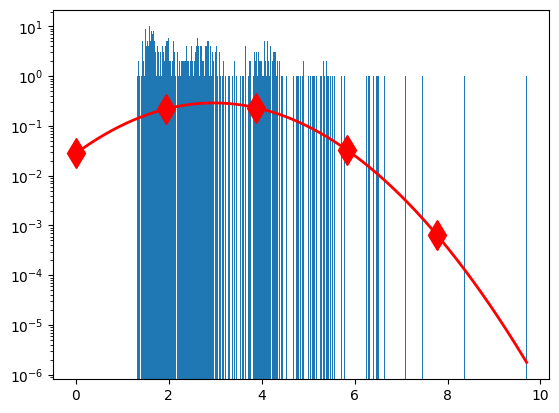

start_training


 75%|███████▌  | 3/4 [09:43<03:14, 194.30s/it]

full grad computed
norm diffs computed


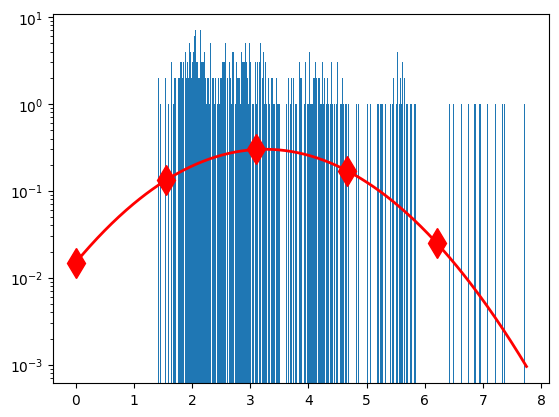

start_training


100%|██████████| 4/4 [12:57<00:00, 194.33s/it]


Running Validation...
  Accuracy: 0.69
 matthews_corrcoef_metric: -0.00


In [ ]:
norm_diffs_every_epoch_ACC=training_and_drawing(model,epochs,optimizer)

(array([193., 147.,  80.,  37.,  13.,   8.,   1.,   0.,   0.,   2.]),
 array([ 1.95466757,  3.06385026,  4.17303295,  5.28221564,  6.39139833,
         7.50058103,  8.60976372,  9.71894641, 10.8281291 , 11.93731179,
        13.04649448]),
 <BarContainer object of 10 artists>)

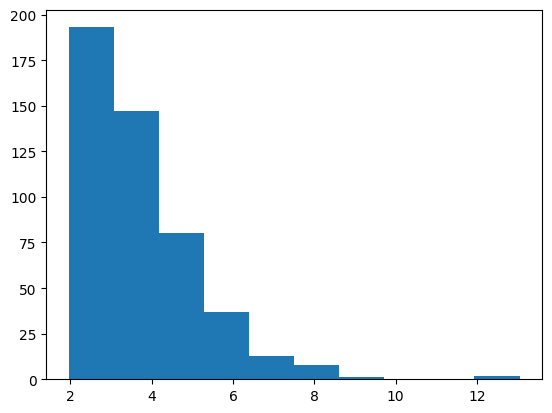

In [ ]:
plt.hist(norm_diffs_every_epoch_ACC[0])

(array([ 86., 112., 109.,  40.,  66.,  13.,  34.,   5.,  10.,   6.]),
 array([1.41934884, 2.05229732, 2.6852458 , 3.31819428, 3.95114276,
        4.58409125, 5.21703973, 5.84998821, 6.48293669, 7.11588517,
        7.74883366]),
 <BarContainer object of 10 artists>)

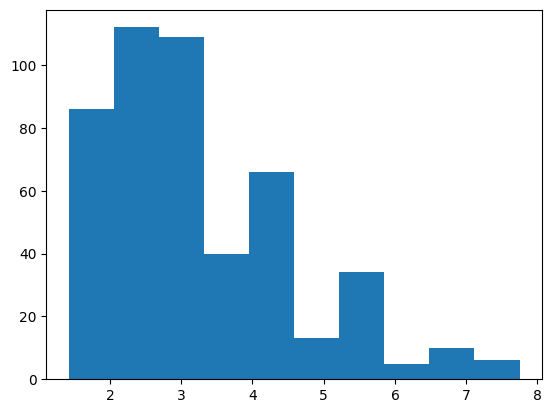

In [ ]:
plt.hist(norm_diffs_every_epoch_ACC[-1])

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

full grad computed
norm diffs computed


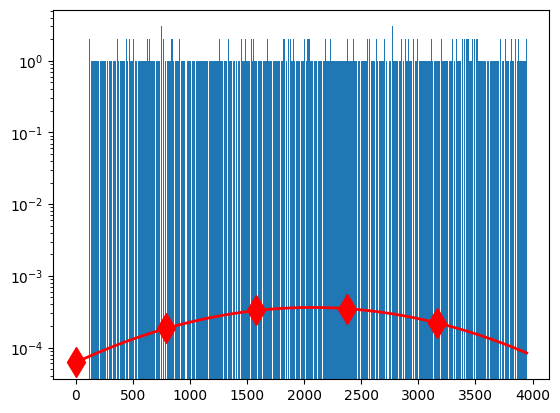

start_training


 25%|██▌       | 1/4 [03:04<09:12, 184.14s/it]

full grad computed
norm diffs computed


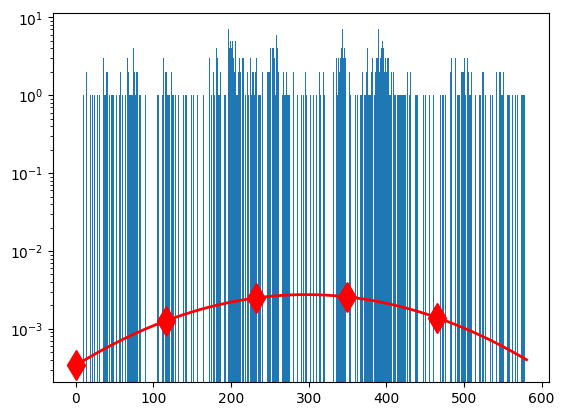

start_training


 50%|█████     | 2/4 [06:07<06:07, 183.56s/it]

full grad computed
norm diffs computed


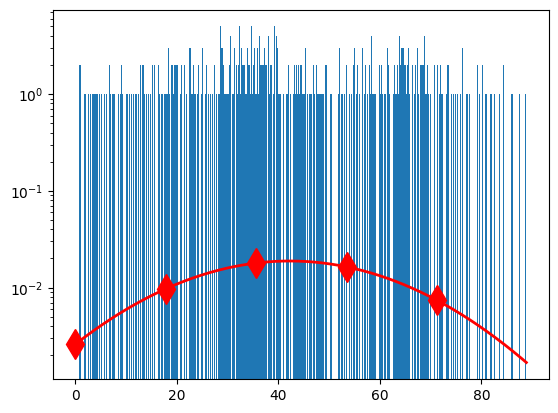

start_training


 75%|███████▌  | 3/4 [09:06<03:01, 181.66s/it]

full grad computed
norm diffs computed


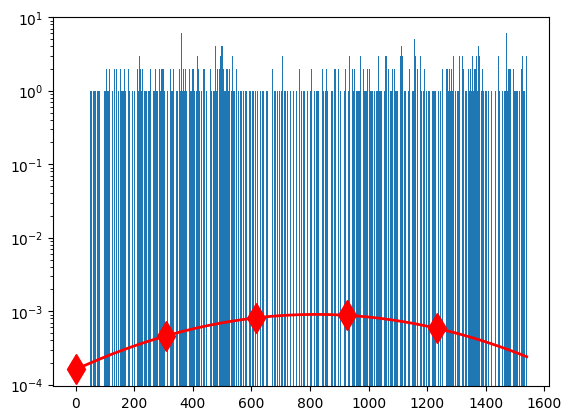

start_training


100%|██████████| 4/4 [12:05<00:00, 181.50s/it]


Running Validation...
  Accuracy: 0.69
 matthews_corrcoef_metric: 0.00


In [ ]:
from torch.optim import Adam
del model
torch.manual_seed(15)
model2 = BertForSequenceClassification.from_pretrained(
  "bert-base-uncased", # 12-ти слойная модель BERT с предобученными весами
  num_labels = 2, # количество выходных хначений для бинарной классификации  
  output_attentions = False, # true, если необходимо брать attention веса модели.
  output_hidden_states = False, #true, если необходимо брать значения со скрытых слоёв.
)
# Tell pytorch to run this model on the GPU.
model2.cuda()

optimizer_adam = Adam(model2.parameters())
norm_diffs_every_epoch_Adam=training_and_drawing(model2,epochs,optimizer_adam)


(array([44., 49., 46., 45., 50., 52., 48., 47., 51., 49.]),
 array([ 119.16682434,  502.05702667,  884.947229  , 1267.83743134,
        1650.72763367, 2033.617836  , 2416.50803833, 2799.39824066,
        3182.28844299, 3565.17864532, 3948.06884766]),
 <BarContainer object of 10 artists>)

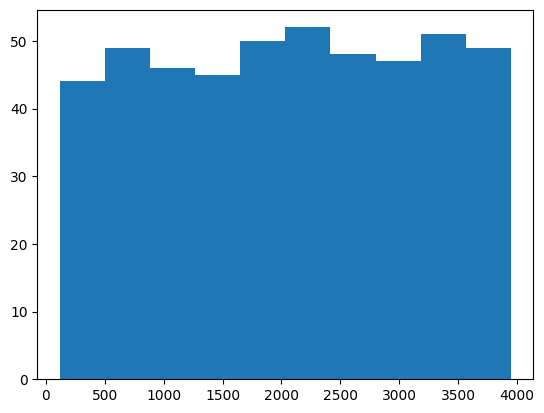

In [ ]:
plt.hist(norm_diffs_every_epoch_Adam[0])

(array([41., 46., 63., 45., 28., 39., 56., 49., 66., 48.]),
 array([  49.28143692,  198.32594948,  347.37046204,  496.41497459,
         645.45948715,  794.50399971,  943.54851227, 1092.59302483,
        1241.63753738, 1390.68204994, 1539.7265625 ]),
 <BarContainer object of 10 artists>)

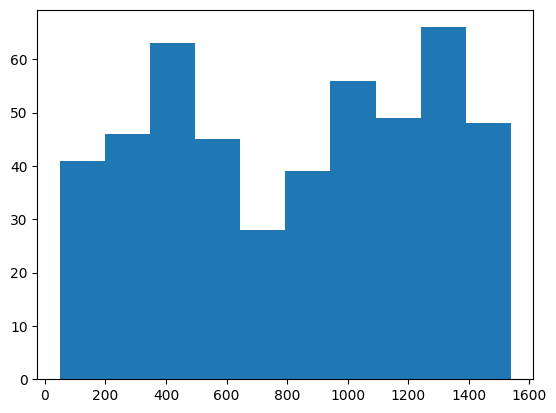

In [ ]:
plt.hist(norm_diffs_every_epoch_Adam[-1])

В задачах распределение отклонения градиента от субградиента далеко от нормального, скоре является равномерным на большом диапазоне. Интерпретируя такое поведение, как "большой хвост" шума в стох.градиенте, предпочтительнее использовать метод Adam.

#### Эксперимент №2 
Сделаем аналогичный эксперимент для изображений


In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
BS=32
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
train_dataloader = torch.utils.data.DataLoader(trainset, batch_size=BS,
                                          shuffle=True, num_workers=2)
valset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform)
validation_dataloader = torch.utils.data.DataLoader(valset, batch_size=BS,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)
BS=1024
train_dataloader_for_full_grad = torch.utils.data.DataLoader(trainset, batch_size=BS,
                                          shuffle=True, num_workers=2)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [ ]:
del model#, model2
model=torchvision.models.vgg16(pretrained=True)
model.requires_grad_(False)
import random

model.classifier[6]=torch.nn.Linear(4096,10)
device=torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
model=model.to(device)

In [ ]:
optimizer=ACC(model.parameters(),
                 lr=1e-4, 
                 betas=(0.9, 0.99), 
                 eps=1e-5,
                 w=1e-5,
                 alpha=2)# ваш оптимизатор здесь
criterion=torch.nn.CrossEntropyLoss()
model.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

  0%|          | 0/4 [00:00<?, ?it/s]

full grad computed
norm diffs computed


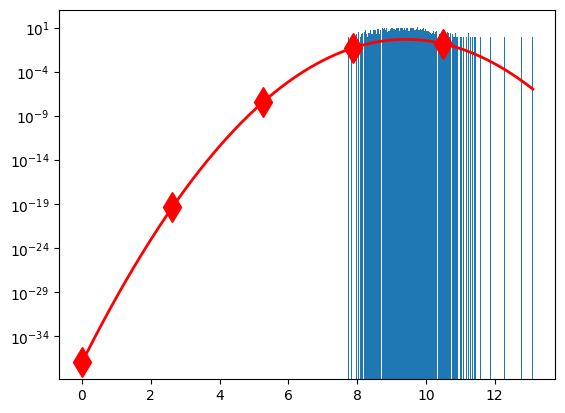

start_training


 25%|██▌       | 1/4 [01:16<03:50, 76.90s/it]

full grad computed
norm diffs computed


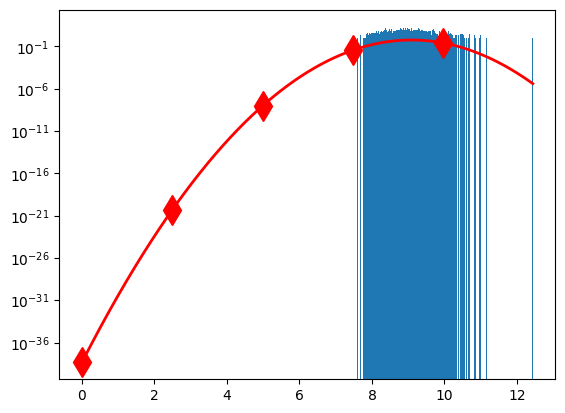

start_training


 50%|█████     | 2/4 [02:27<02:26, 73.44s/it]

full grad computed
norm diffs computed


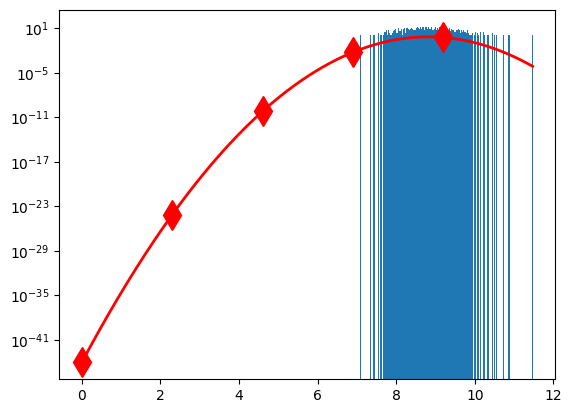

start_training


 75%|███████▌  | 3/4 [03:41<01:13, 73.56s/it]

full grad computed
norm diffs computed


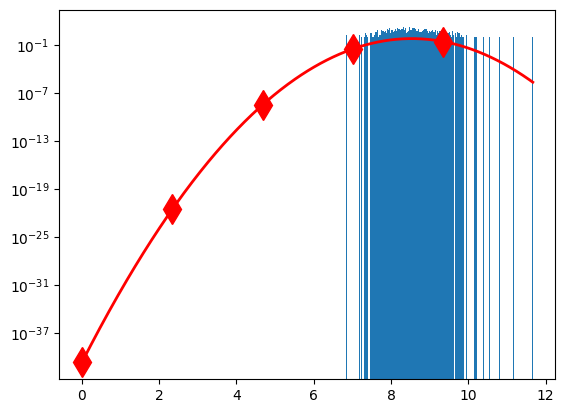

start_training


100%|██████████| 4/4 [04:53<00:00, 73.43s/it]

Running Validation...


  Accuracy: 0.42


In [ ]:
epochs = 4
norm_diffs_every_epoch_ACC=training_and_drawing(model,epochs,optimizer)

In [ ]:
# del model
model3=torchvision.models.vgg16(pretrained=True)
model3.requires_grad_(False)
# import random

model3.classifier[6]=torch.nn.Linear(4096,10)
# device=torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
model3=model3.to(device)
from torch.optim import Adam
optimizer_adam=Adam(model3.parameters())# ваш оптимизатор здесь
criterion=torch.nn.CrossEntropyLoss()
model3.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

  0%|          | 0/4 [00:00<?, ?it/s]

full grad computed
norm diffs computed


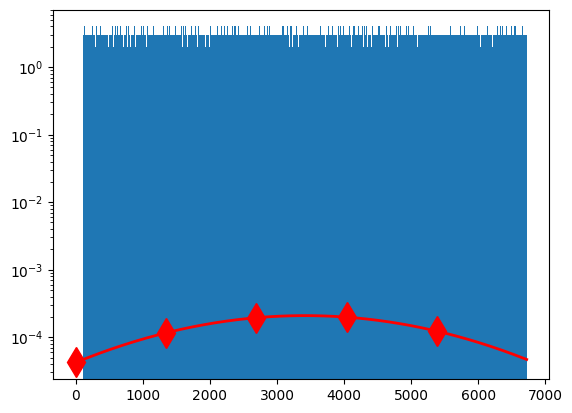

start_training


 25%|██▌       | 1/4 [01:31<04:35, 91.91s/it]

full grad computed
norm diffs computed


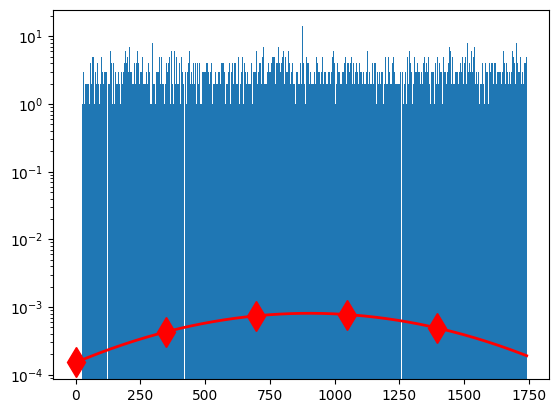

start_training


 50%|█████     | 2/4 [02:54<02:53, 86.52s/it]

full grad computed
norm diffs computed


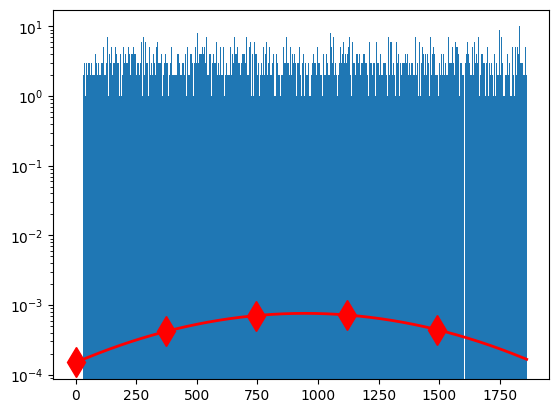

start_training


 75%|███████▌  | 3/4 [04:19<01:25, 85.84s/it]

full grad computed
norm diffs computed


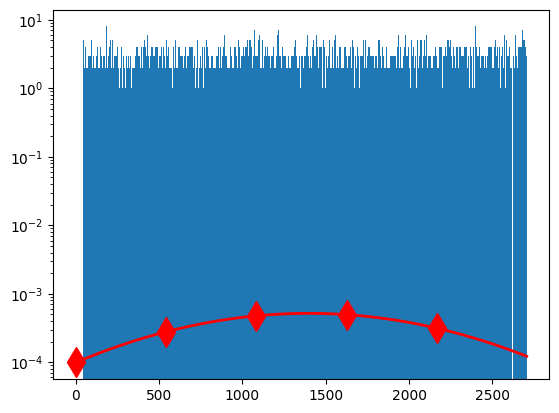

start_training


100%|██████████| 4/4 [05:53<00:00, 88.42s/it]

Running Validation...


  Accuracy: 0.59


In [ ]:
norm_diffs_every_epoch_Adam=training_and_drawing(model3, epochs, optimizer_adam)

(array([147., 152., 144., 168., 149., 164., 149., 160., 164., 166.]),
 array([  41.43498993,  307.91185226,  574.3887146 ,  840.86557693,
        1107.34243927, 1373.81930161, 1640.29616394, 1906.77302628,
        2173.24988861, 2439.72675095, 2706.20361328]),
 <BarContainer object of 10 artists>)

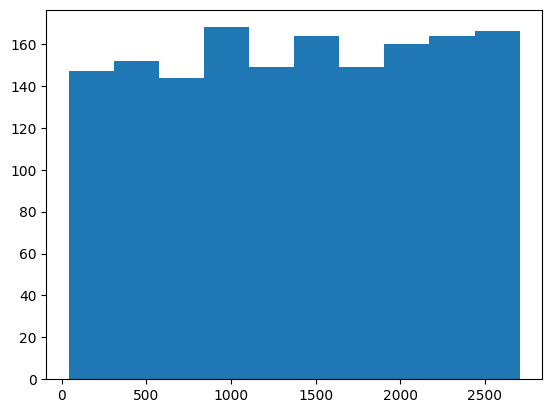

In [ ]:
plt.hist(norm_diffs_every_epoch_Adam[-1])

Добавим функции из семинара

In [ ]:
def get_loss(batch,model):

  inputs, labels = batch

  outputs = model(inputs.to(device))
  loss = criterion(outputs, labels.to(device))

  return loss
def get_accuracy(model,batch):
  inputs, labels = batch

  outputs = model(inputs.to(device))
  
        
        # Calculate the accuracy for this batch of test sentences.
   

  return flat_accuracy(outputs.detach().cpu().numpy(), labels.detach().cpu().numpy())
def flat_accuracy(preds, labels):
  # print(preds.shape())
  pred_flat = np.argmax(preds, axis=1).flatten()
  labels_flat = labels.flatten()
  return np.sum(pred_flat == labels_flat) / len(labels_flat)                
def validation(model):
  print("Running Validation...")
  model.eval()
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0
    # Evaluate data for one epoch
  for batch in validation_dataloader:
    tmp_eval_accuracy = get_accuracy(model,batch)
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1
    # Report the final accuracy for this validation run.

  print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps) )
  # print(" matthews_corrcoef_metric: {0:.2f}".format(np.mean(matthews_set)))

Распределение отклонения стох.градиента от градиента в задаче компьютерного зрения похоже на нормальное. ACC справляется неплохо, Adam на равномерном распределении лучше.

# Задание №3

__*данное задание стоит 6 баллов*__

__*каждый из экспериментов с определенным оптимизатором в каждом пункте стоит 1 балла, эксперименты без объяснения будут оцениваться .25 балла*__ 

Проведите исследование по оптимизации моделей([№1](https://huggingface.co/transformers/model_doc/distilbert.html#distilbertforsequenceclassification) [№2](https://arxiv.org/pdf/1409.1556.pdf)) предложенных ниже, сравните скорости сходимости и полученные результаты для алгоритмов *SGD + Momentum*, *Adam*, *__ACClip__* с различными праметрами:
- 1. lr - коэффициент обучения для всех элгоритмов (0.1, 0.01, 0.001, 0.0001) при фиксированных остальных гиперпараметрах 
  2. gamma - для SGD + momentum (0,9, 0,99, 0,5) для лучшего результата, полученного в пункте 1.
  3. beta1, beta2 - для ACClip, ADAM - для различных значений (0,9, 0,99, 0,5) для лучшего результата, полученного в пункте 1.
Объясните полученные Вами результаты.
В задаче классификации изображений доучите уже предобученные веса , преждевренменно обучив последний линейный слой, для классификации изображений CIFAR10

- Обоснуйте полученные результаты, опираясь на теорию лекции №8


В качестве датасета возьмем один одно из заданий, предложенных в качестве соревнований на [kaggle](https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge)

In [8]:
df = pd.read_csv("https://thigm85.github.io/data/cord19/cord19-query-title-label.csv")
df.head()

,query,title,label
0,coronavirus origin,Monophyletic Relationship between Severe Acute...,1
1,coronavirus origin,Comprehensive overview of COVID-19 based on cu...,1
2,coronavirus origin,"The SARS, MERS and novel coronavirus (COVID-19...",1
3,coronavirus origin,Evidence for zoonotic origins of Middle East r...,1
4,coronavirus origin,Deadly virus effortlessly hops species,1


In [9]:
print('Loading DistilBERT tokenizer...')
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased', do_lower_case=True)


Loading DistilBERT tokenizer...


In [10]:
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
# токенизируем предложения исходного датасета
input_ids = []
# For every sentence...
for sent in df.title.values:
    #   (1) токинизируем предложение.
    #   (2) добавляем символ `[CLS]`в начало предложения.
    #   (3) и символ `[SEP]`в конец.
    #   (4) маркеруем все токены в их id
    encoded_sent = tokenizer.encode(
                        sent,                      
                        add_special_tokens = True, # добавляем '[CLS]' и '[SEP]'
                   )
    
    input_ids.append(encoded_sent)
print('Original: ', df.title.values[0])
print('Token IDs:', input_ids[0])


Loading BERT tokenizer...
Original:  Monophyletic Relationship between Severe Acute Respiratory Syndrome Coronavirus and Group 2 Coronaviruses
Token IDs: [101, 18847, 21281, 7485, 2594, 3276, 2090, 5729, 11325, 16464, 8715, 21887, 23350, 1998, 2177, 1016, 21887, 23350, 2229, 102]


In [11]:
MAX_LEN =  max([len(sen) for sen in input_ids])+1
print('\nPadding/truncating all sentences to %d values...' % MAX_LEN)
print('\nPadding token: "{:}", ID: {:}'.format(tokenizer.pad_token, tokenizer.pad_token_id))

input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", 
                          value=0, truncating="post", padding="post")
print('\Done.')


Padding/truncating all sentences to 125 values...

Padding token: "[PAD]", ID: 0
\Done.


In [12]:
# создадим attantion маску для кажого предложения
attention_masks = []
for sent in input_ids:
    
    # Create the attention mask.
    #   - если  ID = 0 тогда не стоит обрабатывать данный токен в процессе обучения, поскольку это паддинг
    #   - если  ID > 0 тогда стоит использовать данный токен, поскольку он является частью предложения
    att_mask = [int(token_id > 0) for token_id in sent]
    
    attention_masks.append(att_mask)

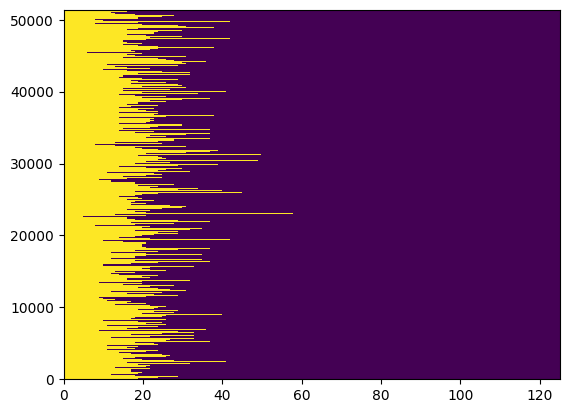

In [13]:
plt.pcolor(attention_masks)

In [14]:
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids,df.label.values, 
                                                            random_state=2018, test_size=0.1)

train_masks, validation_masks, _, _ = train_test_split(attention_masks, df.label.values,
                                             random_state=2018, test_size=0.1)


if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

### даталоадер для вычисления полного градиента
batch_size = 250#train_inputs.shape[0]
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader_for_full_grad = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)


### для обучения
batch_size = 16#train_inputs.shape[0]
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)


There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [15]:
# If there's a GPU available...
if torch.cuda.is_available():    
    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [16]:
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

<ipython-input-16-42a06c90195a>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_inputs = torch.tensor(train_inputs)
<ipython-input-16-42a06c90195a>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  validation_inputs = torch.tensor(validation_inputs)
<ipython-input-16-42a06c90195a>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels = torch.tensor(train_labels)
<ipython-input-16-42a06c90195a>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detac

In [17]:
###full_grad_dataloader
batch_size = 250 #train_inputs.shape[0]
# Create the DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader_for_full_grad = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)


### for training
batch_size = 16#train_inputs.shape[0]
# Create the DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler,  batch_size=len(validation_data)//5)

In [18]:
# загрузим  DistilBertForSequenceClassification с одним выходным слоем и претрененными весами
torch.manual_seed(15)
model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", 
    num_labels = 2, 
    output_attentions = False, 
    output_hidden_states = False, 
)
# model.cuda()
model.to(device)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.weight', 'classifi

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [19]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(preds,labels):
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [57]:
def training(model,n_epochs,optimizer):
  for i in tqdm.tqdm(range(n_epochs)):
    model.train()
    for step, batch in enumerate(train_dataloader):
      optimizer.zero_grad()
      loss=get_loss(batch,model)
      loss.backward()
      optimizer.step()
    validation(model)

def get_metrics(model,batch):
  b_input_ids = batch[0].to(device)
  b_input_mask = batch[1].to(device)
  b_labels = batch[2].to(device)
  with torch.no_grad():
    outputs = model(b_input_ids,  
                      attention_mask=b_input_mask, 
                      labels=b_labels)
  logits = torch.argmax(outputs.logits,1).detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
        
        # Calculate the accuracy for this batch of test sentences.

  return compute_metrics(logits, label_ids)
           
def validation(model):
  print("Running Validation...")
  acc_set=[]
  f1_set=[]
  precision_set=[]
  recall_set=[]
  model.eval()
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0
    # Evaluate data for one epoch
  for batch in validation_dataloader:
    computed_results= get_metrics(model,batch)
    acc_set.append(computed_results['accuracy'])
    f1_set.append(computed_results['f1'])
    precision_set.append(computed_results['precision'])
    recall_set.append(computed_results['recall'])

    # Report the final accuracy for this validation run.

  print("  Accuracy: {0:.2f}".format(np.mean(acc_set)) )
  print(" f1=: {0:.2f}".format(np.mean(f1_set)))
  print(" precision=: {0:.2f}".format(np.mean(precision_set)))
  print(" recall=: {0:.2f}".format(np.mean(recall_set)))


### Пункт №1(оптимизация языковой модели) 
Ваши эксперименты здесь

In [58]:
def get_loss(batch,model):
  b_input_ids = batch[0]#.to(device)
  b_input_mask = batch[1]#.to(device)
  b_labels = batch[2]#.to(device)
    ##############Bug fix code####################
  b_input_ids = b_input_ids.type(torch.LongTensor)
  b_input_mask = b_input_mask.type(torch.LongTensor)
  b_labels = b_labels.type(torch.LongTensor)

  b_input_ids = b_input_ids.to(device)
  b_input_mask = b_input_mask.to(device)
  b_labels = b_labels.to(device)
    ############################################
  outputs = model(input_ids = b_input_ids, attention_mask=b_input_mask, labels=b_labels)
  # inputs, masks, labels = batch
  # outputs = model(inputs.to(device))
  # loss = criterion(outputs, labels.to(device))
  return outputs.loss #loss

def get_accuracy(model,batch):
  inputs, _, labels = batch
  with torch.no_grad():
    outputs = model(inputs.to(device))[:2]
        # Calculate
  return flat_accuracy(torch.stack(outputs).cpu().numpy(), labels.detach().cpu().numpy())

def flat_accuracy(preds, labels):
  # print(preds.shape())
  pred_flat = np.argmax(preds, axis=1).flatten()
  labels_flat = labels.flatten()
  return np.sum(pred_flat == labels_flat) / len(labels_flat)  

def validation(model):
  print("Running Validation...")
  model.eval()
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0
    # Evaluate data for one epoch
  for batch in validation_dataloader:
    tmp_eval_accuracy = get_accuracy(model,batch)
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1
    # Report the final accuracy for this validation run.

  print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps) )

In [56]:
print('ACC experiments')
criterion=torch.nn.CrossEntropyLoss()
for lr in [0.1, 0.01, 0.001, 0.0001]:
  print(lr)
  n_epochs = 2
  total_steps = len(train_dataloader) * n_epochs
  torch.manual_seed(15)
  model = DistilBertForSequenceClassification.from_pretrained(
      "distilbert-base-uncased", 
      num_labels = 2, 
      output_attentions = False, 
      output_hidden_states = False, 
  )
  model.to(device)
  optimizer = ACC(model.parameters(), lr=lr) # исследуемый оптимизатор здесь
  training(model,n_epochs,optimizer)
  del model

ACC experiments
0.1


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.weight', 'classifi

Running Validation...


<ipython-input-55-83e74346ad37>:35: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  return np.sum(pred_flat == labels_flat) / len(labels_flat)
 50%|█████     | 1/2 [00:19<00:19, 19.12s/it]

  Accuracy: 0.00
Running Validation...


100%|██████████| 2/2 [00:37<00:00, 18.81s/it]

  Accuracy: 0.00
0.01



Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.weight', 'classif

Running Validation...


  0%|          | 0/2 [00:07<?, ?it/s]


KeyboardInterrupt: ignored

In [ ]:
for beta1 in [0.9, 0.99, 0.5]:
  for beta2 in [0.9, 0.99, 0.5]:
    print('beta1', beta1, 'beta2', beta2)
    optimizer = ACC(model.parameters(), lr=lr, beta1=beta1, beta2=beta2) # исследуемый оптимизатор здесь
    n_epochs = 2
    total_steps = len(train_dataloader) * n_epochs
    torch.manual_seed(15)
    model = DistilBertForSequenceClassification.from_pretrained(
        "distilbert-base-uncased", 
        num_labels = 2, 
        output_attentions = False, 
        output_hidden_states = False, 
    )
    model.cuda()
    training(model,n_epochs,optimizer)
    del model

### Пункт №2 (оптимизация модели обработки изображений)
Ваши эксперименты здесь

Аналогичное задание для обработки изображений

In [ ]:

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
BS=32
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
train_dataloader = torch.utils.data.DataLoader(trainset, batch_size=BS,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
model=torchvision.models.vgg32(pretrained=True)
model.requires_grad_(False)

model.classifier[6]=torch.nn.Linear(4096,10) #после небольшой адаптации весов последнего слоя все остальные веса предобученной модели имеет смысл разморозить
device=torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
model=model.to(device)
# optimizer=#оптимизатор здесь

optimizer = ACC(model.parameters())# исследуемый оптимизатор здесь
# Number of training epochs (authors recommend between 2 and 4)
# epochs = 4
# Total number of training steps is number of batches * number of epochs.
# total_steps = len(train_dataloader) * epochs

criterion=torch.nn.CrossEntropyLoss()
model.eval()